In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

In [7]:
def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

import math
def plotlimit(ax,expected_CLs,poi_values,showBands = True):

    # expected CLs
    ax.plot(
        poi_values, expected_CLs[:, 2], "--", color="black", label=r"expected CL$_S$"
    )

    if showBands:
        # 1 and 2 sigma bands
        ax.fill_between(
            poi_values,
            expected_CLs[:, 1],
            expected_CLs[:, 3],
            color="limegreen",
            label=r"expected CL$_S$ $\pm 1\sigma$",
        )
        ax.fill_between(
            poi_values,
            expected_CLs[:, 0],
            expected_CLs[:, 4],
            color="yellow",
            label=r"expected CL$_S$ $\pm 2\sigma$",
            zorder=0,  # draw beneath 1 sigma band
        )
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="137")

    
    return ax

## return the xsec function for mass=X
def f_xsec(m):
    def xsec_m(x):
        if m==1: xs_ctau_100 = 135.7
        if m==2: xs_ctau_100 = 4.2380
        if m==4: xs_ctau_100 = 0.128900            
        return xs_ctau_100/(x/100)  ## x in mm, xs in pb
    return xsec_m
## return the V^2 function for ctau
def f_ctau(m):
    def ctau_m(x):
        if m==1: v2_ctau_100 = 4.14E-03
        if m==2: v2_ctau_100 = 1.29E-04
        if m==4: v2_ctau_100 = 3.95E-06            
        return v2_ctau_100/(x/100)  ## x in mm, xs in pb
    return ctau_m


## find intersection of limit band with theory xsec
from scipy.optimize import fsolve

def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return funcs[i](x)-xsec(x) 
        return eq_i

    sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

from scipy.interpolate import Rbf
import numpy as np
def interpolate1D(combineLimits,x,nBins=10):
    epsilon = 0.2
    smooth = 1
#     nBins = 10
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(5):
        y = combineLimits[:,i]
        rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)
#         rbfi = Rbf(x,y,function='cubic', epsilon=epsilon,smooth=smooth)
        yi = rbfi(xi)
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs

1.29e-06

In [3]:
arr4GeV =[]
ctau = []
for f in glob.glob("../limit/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root"):
    ct = f.split("/")[2].split("_")[4].replace("pl","")
    xsec = 0.128900/(float(ct)/100)
    print(ct,xsec)    
    arr4GeV.append(loadLimits(f)*xsec)
    ctau.append(float(ct))
arr4GeV = np.array(arr4GeV)
ctau4GeV = np.array(ctau)

800 0.0161125
500 0.025779999999999997
200 0.06445
80 0.16112499999999996
100 0.1289
1000 0.012889999999999999
2000 0.006444999999999999
50 0.2578
1500 0.008593333333333333


In [5]:
arr1GeV =[]
ctau = []

for f in glob.glob("../limit/higgsCombine_HNL_muonType_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root"):
    signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
    card = "../limit/combine/HNL_datacards/%s_CSC.txt"%signalName
    norm = float(open(card,'r').readline().split()[-1])
    ct = f.split("/")[2].split("_")[4].replace("pl","")
    xsec = 135.7000/(float(ct)/100)
    arr1GeV.append(loadLimits(f)*xsec/norm)
    print(ct,xsec, loadLimits(f)*xsec, norm)        
    ctau.append(float(ct))
arr1GeV = np.array(arr1GeV)
ctau1GeV = np.array(ctau)

100 135.7 [0.82617645 0.98846111 1.25893555 1.70053458 2.29895155 1.26646161] 100.0
1000 13.569999999999999 [0.24485054 0.29342917 0.36442871 0.48644951 0.65645243 0.36684972] 10.0
5000 2.714 [0.10824154 0.12963118 0.16299902 0.21627616 0.28939517 0.1629114 ] 1.0
2000 6.784999999999999 [0.45587236 0.54261891 0.68247559 0.90282611 1.2096868  0.6833295 ] 10.0


In [6]:
arr2GeV =[]
ctau = []
for f in glob.glob("../limit/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root"):
    ct = f.split("/")[2].split("_")[4].replace("pl","")
    xsec = 4.2380/(float(ct)/100)
    print(ct,xsec)    
    arr2GeV.append(loadLimits(f)*xsec)
    ctau.append(float(ct))
arr2GeV = np.array(arr2GeV)
ctau2GeV = np.array(ctau)

2000 0.21190000000000003
800 0.52975
100 4.238
1500 0.28253333333333336
10 42.38
1000 0.42380000000000007
5000 0.08476
10000 0.04238


In [149]:
arr4GeV[:,0]

array([0.00623322, 0.00603196, 0.0109645 , 0.07342649, 0.04005801,
       0.00668161, 0.00978708, 0.41036523, 0.00814017])

In [7]:
mapToV2={
    "1GeV":{100:4.14E-03},
    "2GeV":{100:1.29E-04},
    "4GeV":{100:3.95E-06},    
}

In [64]:
arr3

array([5.65856934e-01, 7.76904583e-01, 1.14062500e+00, 1.70440090e+00,
       2.40038276e+00, 6.75828125e+02])

In [63]:
arr2_b

array([  3.17382812,   3.96232605,   5.078125  ,   6.75817966,
         9.03085518, 675.82812024])

In [65]:
ctau4GeV

array([ 800.,  500.,  200.,   80.,  100., 1000., 2000.,   50., 1500.])

In [46]:
f_xsec(4)(x)

array([0.18365451, 0.17497131, 0.16709649, 0.1584937 , 0.13063352])

In [45]:
x

array([70.18613339, 73.66922238, 77.14105656, 81.32815172, 98.67298796])

In [44]:
x = intersect(funcs, f_xsec(4),70)

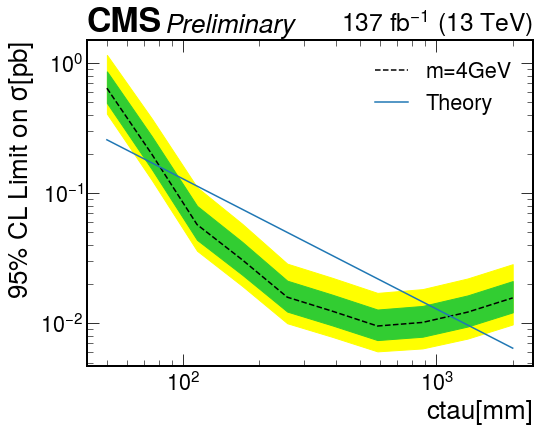

In [11]:
ctau = [50,100,1000]
xSection4GeV = np.array([0.128900*2,0.128900,0.128900/10,])

m4GeV_i, ctau_i, funcs = interpolate1D(arr4GeV, ctau4GeV)
ct_xing_4 = intersect(funcs, f_xsec(4),1000)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

ax = plotlimit(ax,m4GeV_i,ctau_i,True)
xSection4GeV = 0.128900/(ctau_i/100)

ax.plot(ctau_i,xSection4GeV,label="Theory")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend(["m=2GeV","Theory"])
ax.legend(["m=4GeV","Theory"])
# ax.legend(["m=7GeV","Theory"])

In [116]:
funcs[0](ctau_i)

array([3.39047357, 0.01656077, 0.01044071, 0.01191657, 0.01612292,
       0.01703012, 0.03862158, 0.07502932])

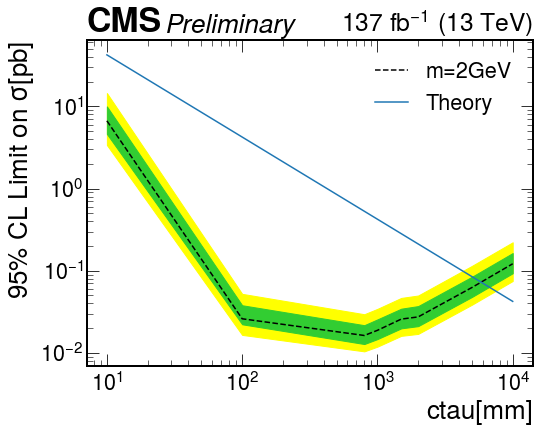

In [13]:
m2GeV_i, ctau_i,funcs_2 = interpolate1D(arr2GeV, ctau2GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m2GeV_i,ctau_i,True)
xSection2GeV = 4.2380/(ctau_i/100)
# ax = plotlimit(ax,m7GeV,ctau)

ax.plot(ctau_i,xSection2GeV,label="Theory")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(["m=2GeV","Theory"])

In [68]:
arr1GeV

array([array([0.82617645, 0.98846111, 1.25893555, 1.70053458, 2.29895155,
       1.26646161]),
       array([0.24485054, 0.29342917, 0.36442871, 0.48644951, 0.65645243,
       0.36684972]),
       array([1.49084473, 1.20671773])], dtype=object)

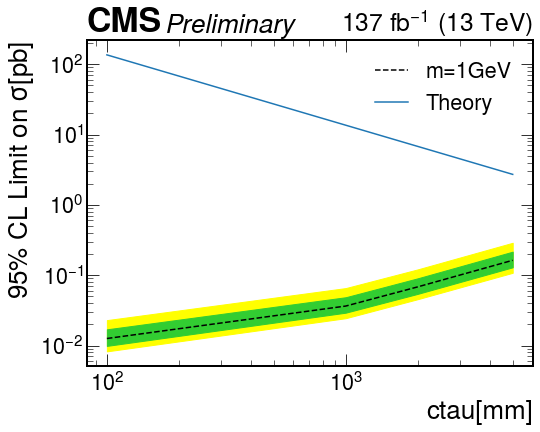

In [92]:
m1GeV_i, ctau_i = interpolate1D(arr1GeV, ctau1GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m1GeV_i,ctau_i,True)
xSection1GeV = 135.7000/(ctau_i/100)

ax.plot(ctau_i,xSection1GeV,label="Theory")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(["m=1GeV","Theory"])

In [17]:
def interpolate2D(combineLimits,x,y,nBins=10):
    epsilon = 0.2
    smooth = 1
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = x
        yi = y
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    for i in range(5):
        z = combineLimits[:,i]
        rbfi = Rbf(x,y,z,function='multiquadric', epsilon=epsilon,smooth=smooth)
#         rbfi = Rbf(x,y,function='cubic', epsilon=epsilon,smooth=smooth)
        myXI, myYI = np.meshgrid(xi,yi)
        zi = rbfi(myXI,myYI)
        newLimits.append(zi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, myXI,myYI

In [18]:
x= np.concatenate([np.ones_like(ctau4GeV)*4,2*np.ones_like(ctau2GeV)],axis=0)

In [19]:
y=np.concatenate([ctau4GeV,ctau2GeV],axis=0)

In [22]:
z = np.concatenate([arr4GeV,arr2GeV],axis=0)

In [27]:
z[:,3]

array([ 0.01318735,  0.01260592,  0.02334118,  0.16329081,  0.08882983,
        0.0142238 ,  0.02108977,  0.86800341,  0.0175409 ,  0.0438945 ,
        0.02175238,  0.02693847,  0.03453834, 10.01427176,  0.02558645])

In [59]:
h = hist.Hist("Expected Limit",
         hist.Bin("ct","ctau[mm]",np.logspace(0,np.log(max(y)),len(y)+1)),
         hist.Bin("m",'mass[GeV]',5,0,5)
        )
h.fill(ct = y,m=x, weight=z[:,2])

In [46]:
z[:,2]

array([0.00985002, 0.00941574, 0.01743423, 0.11675269, 0.06369473,
       0.01062418, 0.01565934, 0.6445    , 0.01302427, 0.03259204,
       0.01629602, 0.01862402, 0.02579772, 6.68395508, 0.01883096])

In [50]:
import matplotlib

(1, 10000.0)

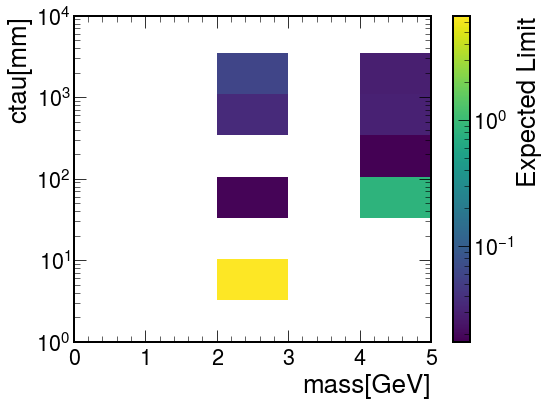

In [60]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

hist.plot2d(h,xaxis="m",ax=ax,patch_opts={"norm":matplotlib.colors.LogNorm()})

ax.set_yscale("log")
ax.set_ylim(1,1e4)

In [272]:
zi, xi,yi = interpolate2D(z,x,y,-1)

In [293]:
z = zi[:,:,3]

In [294]:
z.shape

(15, 15)

In [288]:
xi.shape

(15, 15)

In [83]:
arr3*3.95E-06

array([2.23513489e-06, 3.06877310e-06, 4.50546875e-06, 6.73238354e-06,
       9.48151189e-06, 2.66952109e-03])

# V^2, M plot

NameError: name 'limits1000' is not defined

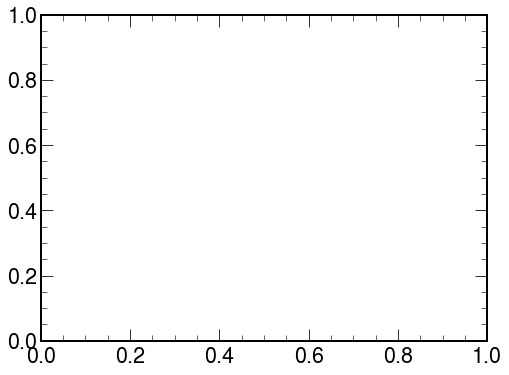

In [4]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits1000,[2,4])
# ax = plotlimit(ax,limits100,[2,4])
ax.plot([1,1,1],[4.14E-02,4.14E-03,4.14E-04],marker="*",ms=12,lw=0)
ax.plot([2,2,2],[1.29E-03,1.29E-04,1.29E-05],marker="*",ms=12,lw=0)
ax.plot([4,4,4],[3.95E-05,3.95E-06,3.95E-07],marker="*",ms=12,lw=0)

ax.set_yscale("log")
ax.set_ylabel("$|V_{l\mu}|^2$")
ax.set_xlabel("Mass[GeV]")
# ax.legend()

In [52]:
ct_xing_2

array([7479.65005984, 6695.19781496, 5843.74908441, 5007.09703392,
       4277.0029333 ])

In [59]:
f_ctau(2)(ct_xing_2)

array([1.72467962e-06, 1.92675412e-06, 2.20748698e-06, 2.57634312e-06,
       3.01613073e-06])

In [60]:
f_ctau(4)(ct_xing_4)

array([2.54624844e-07, 2.92348882e-07, 3.46267977e-07, 4.24749924e-07,
       5.37401594e-07])

In [68]:
arr4GeV

array([[0.00623322, 0.00764603, 0.00985002, 0.01318735, 0.01770608,
        0.00983589],
       [0.00603196, 0.00735375, 0.00941574, 0.01260592, 0.01692542,
        0.00940707],
       [0.0109645 , 0.01349173, 0.01743423, 0.02334118, 0.03157101,
        0.0174122 ],
       [0.07342649, 0.08899684, 0.11675269, 0.16329081, 0.22845145,
        0.11659221],
       [0.04005801, 0.04855246, 0.06369473, 0.08882983, 0.12364547,
        0.06373764],
       [0.00668161, 0.00825248, 0.01062418, 0.0142238 , 0.01923894,
        0.01061771],
       [0.00978708, 0.01212681, 0.01565934, 0.02108977, 0.02844714,
        0.01569953],
       [0.41036523, 0.49633659, 0.6445    , 0.86800341, 1.16228493,
        0.6433723 ],
       [0.00814017, 0.01008618, 0.01302427, 0.0175409 , 0.02366021,
        0.01300869]])

Text(1, 23.0, 'Mass[GeV]')

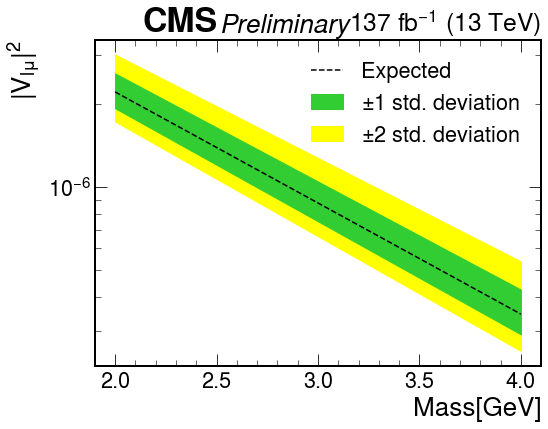

In [20]:
plt.style.use(hep.style.CMS) 

ct_xing_4 = intersect(funcs, f_xsec(4),1000)
ct_xing_2 = intersect(funcs_2, f_xsec(2),10000)

limits = np.array([f_ctau(2)(ct_xing_2),f_ctau(4)(ct_xing_4)])
masses = [2,4]

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)


ax.legend(["Expected",r"$\pm$1 std. deviation",r"$\pm$2 std. deviation"])
ax.set_yscale("log")
ax.set_ylabel("$|V_{l\mu}|^2$")
ax.set_xlabel("Mass[GeV]")
# ax.legend()

## Rbf (radial basis function interpolation)

In [3]:
from scipy.interpolate import Rbf
import numpy as np

In [66]:
rng = np.random.default_rng()
# x = rng.random((1, 50))
x = np.random.normal(size=50)
y = x*x
rbfi = Rbf(x,y)  # radial basis function interpolator instance
xi = np.linspace(0, 1, 20)
yi = rbfi(xi)   # interpolated values
yi.shape

(20,)

In [82]:
m4GeV[:,1]

array([0.49633659, 0.04855246, 0.00791557])

In [84]:
m4GeV.transpose()[1]

array([0.49633659, 0.04855246, 0.00791557])

In [ ]:
def interpolate1D(combineLimits,x):
    rbfi = Rbf(x,y, )